# Projeto - Séries Temporais
## Residência em Ciência de Dados - SAMSUNG/UFPE

### Alunos:
- Lucas Couri (lncc2)
- Mariama Oliveira (mcso)

# Bibliotecas

In [80]:
#import statsmodels.api as sm
import statsmodels.tsa.api as tsa
#from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score
import pmdarima as pm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=Warning)
#import matplotlib as mpl
#import seaborn as sns
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.model_selection import learning_curve
from sklearn.neighbors import KNeighborsRegressor

#mpl.rcParams['figure.figsize'] = [10, 5]

results = {}

Utilizamos o dataset disponível no Kaggle sobre as temperaturas médias em Delhi (https://www.kaggle.com/datasets/mahirkukreja/delhi-weather-data). O dataset já era dividido em train e test, portanto, juntamos os dois datasets para depois separar em train e test da forma desejada.

In [81]:
#https://www.kaggle.com/datasets/mahirkukreja/delhi-weather-data
df = pd.read_csv("temp_delhi.csv")

In [82]:
df = df[["date", "meantemp"]]
df['date'] = pd.to_datetime(df['date'], format='%m/%d/%Y')
df.set_index(df['date'], inplace=True) 
df = df.drop('date', 1)


In [83]:
df.shape

(1575, 1)

In [84]:
df.tail()

,meantemp
date,
2017-04-20,34.500
2017-04-21,34.250
2017-04-22,32.900
2017-04-23,32.875
2017-04-24,32.000


Separando dados em treino, teste e validação. Vale notar que para os modelos lineares utilizaremos apenas treino (75%) e teste (25%), enquanto que para os modelos de machine learning utilizaremos treino (50%), validação (25%) e teste (25%).

In [85]:
df_train = df.iloc[:int(len(df) * 0.75)]
df_test = df.iloc[int(len(df) * 0.75):]

#df_train2 = df.iloc[:int(len(df) * 0.5)]
#df_valid2 = df.iloc[int(len(df) * 0.5):int(len(df) * 0.75)]
#df_test2 = df.iloc[int(len(df) * 0.75):]

#### Funções de apoio

Algumas funções construídas para exibir e salvar as métricas de cada modelo e plotar os gráficos de ajuste e predição.

In [86]:
def show_metrics(y_test,prediction, results, name):
    print(f'{name} - model Results')
    print('r2' , r2_score(prediction, y_test))
    print('mse' ,mean_squared_error(prediction, y_test))
    print('mae', mean_absolute_error(prediction, y_test))
    print('mape', mean_absolute_percentage_error(prediction, y_test))
    results[name] = {'r2':r2_score(prediction, y_test), \
                    'mse': mean_squared_error(prediction, y_test), 
                    'mae': mean_absolute_error(prediction, y_test),
                    'mape': mean_absolute_percentage_error(prediction, y_test)}

def graf_ajuste(pred, train, titulo):
    #Previsão do treino
    fig, ax = plt.subplots()
    ax.plot(pred, label='pred')
    ax.plot(train, label='true')
    plt.title(titulo)
    plt.legend()

def graf_pred(fitted, train, test, titulo, SVR=False):
    
    if(SVR==True):
        fc = fitted
        fc_series = pd.Series(fc, index=test.index[1:])
    else:
        fc = fitted.forecast(394, alpha=0.05)  # 95% conf
        fc_series = pd.Series(fc, index=test.index)

    # Plot
    #plt.figure(figsize=(12,5), dpi=100)
    plt.plot(train, label='Treino')
    plt.plot(test, label='Teste')
    plt.plot(fc_series, label='Predição')
    plt.title(titulo)
    plt.legend(loc='upper left', fontsize=8)
    plt.show()

## Plot

Plotando a série temporal da temperatura média de Delhi

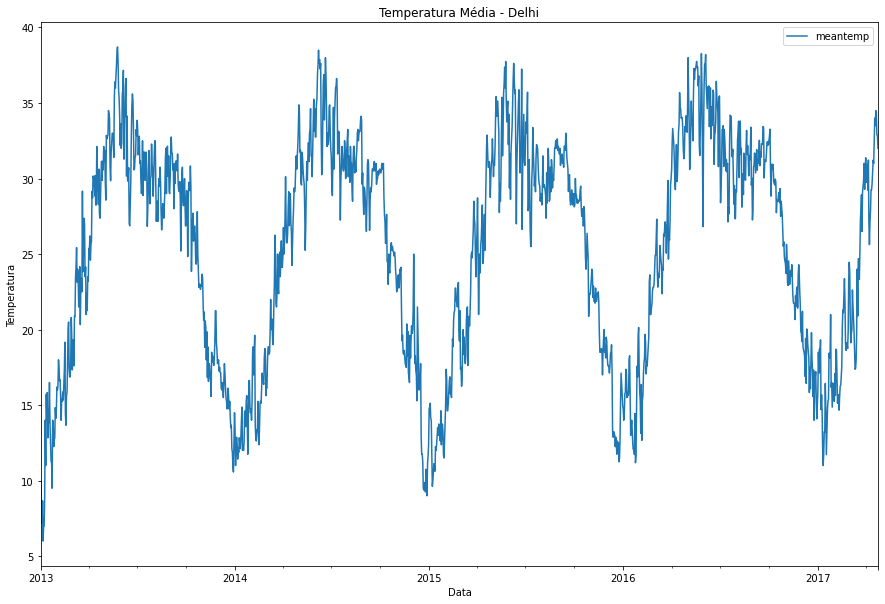

In [87]:
df.plot()
plt.title("Temperatura Média - Delhi")
plt.xlabel("Data")
plt.ylabel("Temperatura")
plt.rcParams["figure.figsize"] = (15,10)
plt.show()

## Decomposição

Através da decomposição verificamos que há tendência... portanto a série não deve ser estacionária, vamos verificar a seguir.

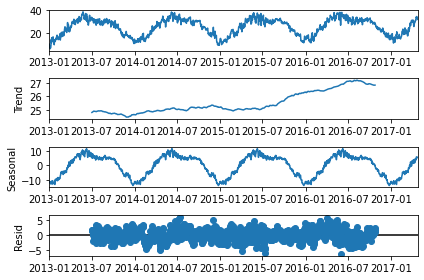

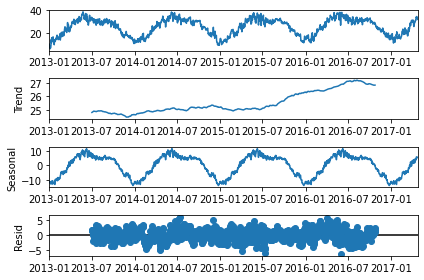

In [88]:
from pylab import rcParams
rcParams['figure.figsize'] = 6, 4
df_decomp = tsa.seasonal_decompose(df, period=365)
df_decomp.plot()

## Autocorrelação e Estacionariedade

Como a função de auto correlação abaixo não decai  para zero, suspeitamos de que a série não seja estacionária. Vamos verificar a seguir por meio de um teste de hipóteses.

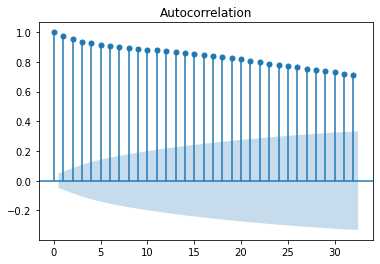

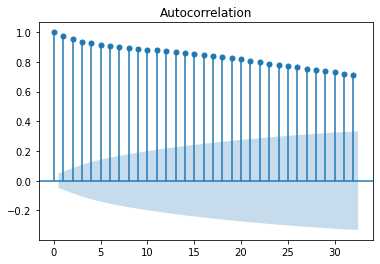

In [89]:
plot_acf(df)

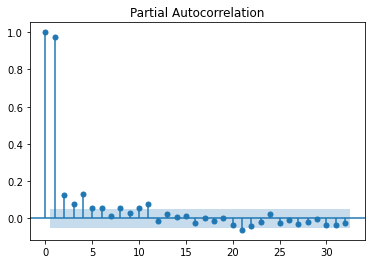

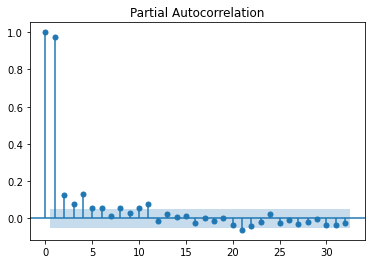

In [90]:
plot_pacf(df)

Considerando um nível de confiança de 0,05 verificamos que o teste de Dickey-Fuller nos leva a não rejeitar a hipótese nula de não estacionariedade, visto que o p-valor = 0,149 (>0,05). Portanto, temos evidências para acreditar que a série não é estacionária.

In [91]:
test, pvalue, lags, obs, critic, ic = tsa.stattools.adfuller(df)
print(pvalue)
print(lags)

0.14882501558674888
10


## Diferenciação

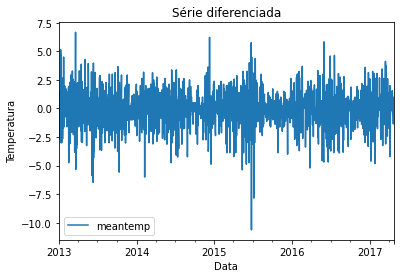

In [92]:
df.diff().plot()
plt.title("Série diferenciada")
plt.xlabel("Data")
plt.ylabel("Temperatura")
plt.rcParams["figure.figsize"] = (15,10)
plt.show()

Após diferenciar a série aparenta ser estacionária, vamos verificar com o teste de Dickey-Fuller.

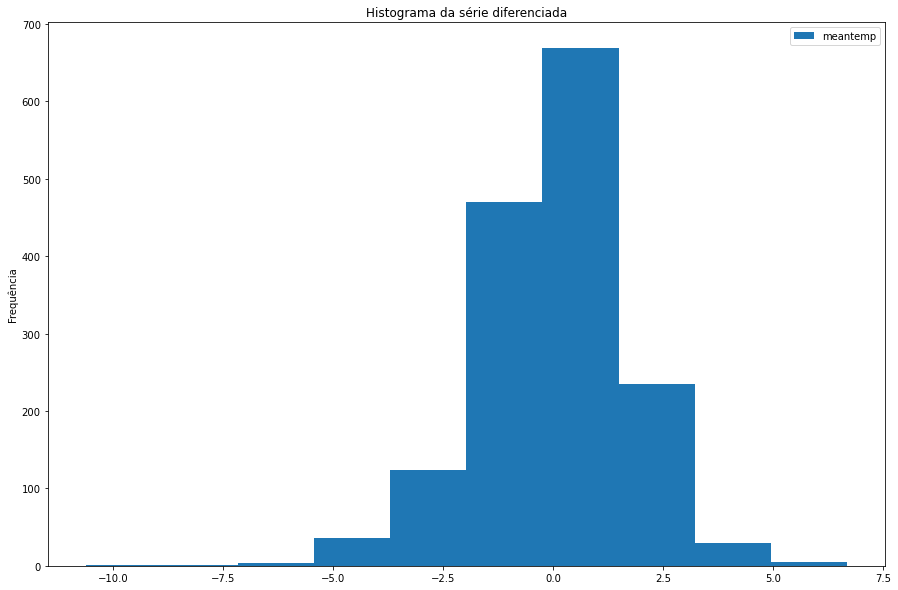

In [93]:
df.diff().plot.hist()
plt.title("Histograma da série diferenciada")
plt.ylabel("Frequência")
plt.rcParams["figure.figsize"] = (15,10)
plt.show()

In [94]:
dfd1 = df.diff().dropna()

Como o p-valor<0,05 então decidimos rejeitar a hipótese nula de não estacionariedade à um nível de confiança de 0,05. Portanto, após diferenciar uma vez a série temos evidências para acreditar que a série se tornou estacionária.

In [95]:
test, pvalue, lags, obs, critic, ic = tsa.stattools.adfuller(dfd1)
print(pvalue)
print(lags)

9.593523131253509e-30
9


## Autocorrelação da série diferenciada

### Correlação

Correlação com série diferenciada

In [96]:
dfd1.corrwith(dfd1.shift(1))

meantemp   -0.156369
dtype: float64

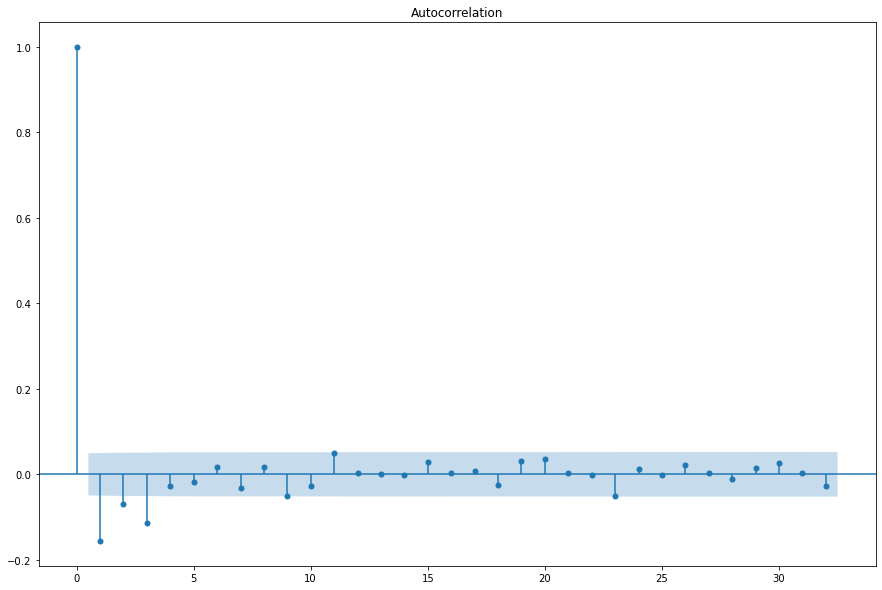

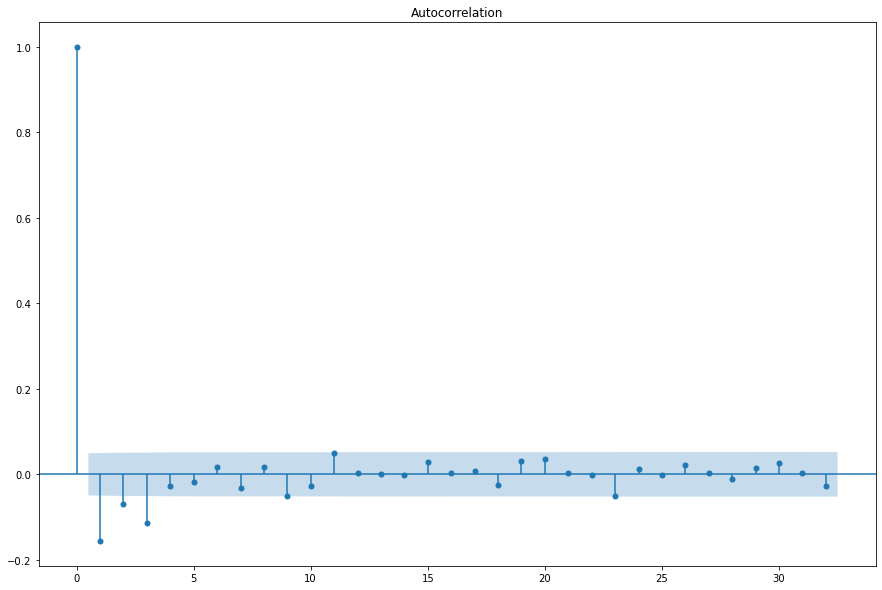

In [97]:
plot_acf(dfd1)

Verificamos a partir do comportamento da função de autocorrelação acima que os lags são significantes até o lag 3, e a partir dele se tornam não significativos. 

## Autocorrelação Parcial

Correlação Parcial com série diferenciada

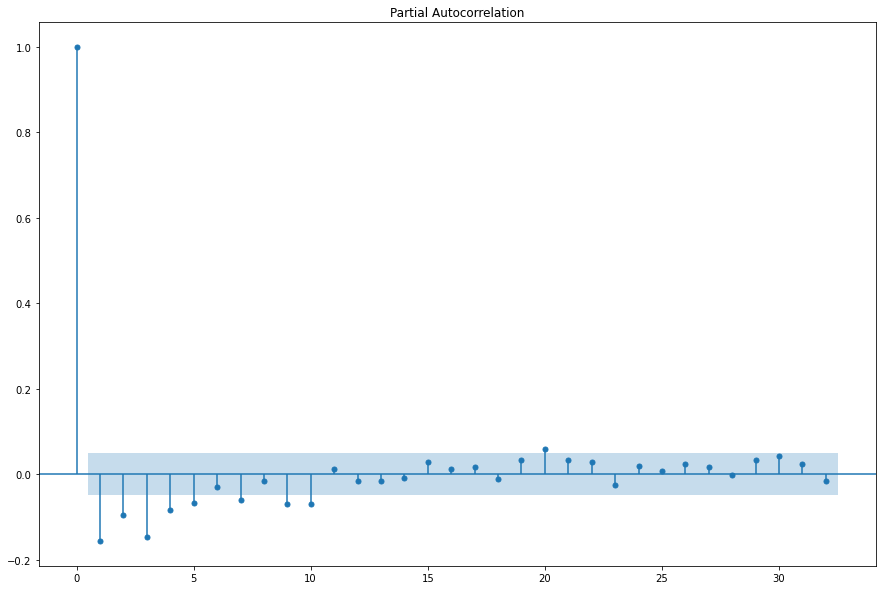

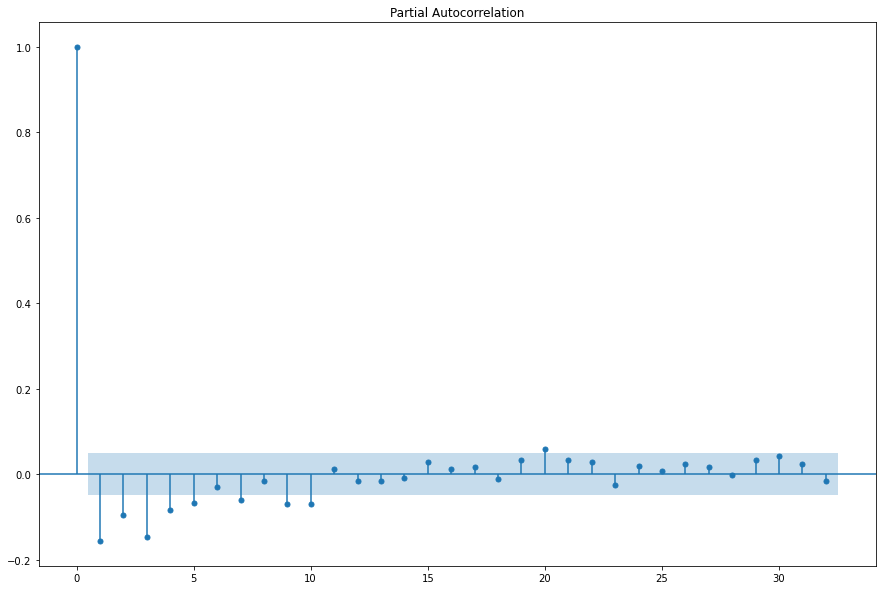

In [98]:
plot_pacf(dfd1)

Verificamos a partir da função de autocorrelação parcial acima que a partir do lag5 os lags se tornam não significativos. Analisando de forma mais conservadora é possível argumentar que o lag5 está bem próximo do limite.

### ARIMA

In [99]:
df_train.index = pd.DatetimeIndex(df_train.index.values, freq=df_train.index.inferred_freq)
#df_train.head()

Função para realizar o ajuste dos modelos ARIMA

In [100]:
def perform_arima(p,d,q,data):
    arima_model = ARIMA(data, order=(p,d,q))
    res_arima = arima_model.fit()
    print(res_arima.summary())
    res_arima.plot_diagnostics()
    return res_arima


#### ARIMA (5,1,3)

A partir da analise dos gráficos da função de autocorrelação e autocorrelação parcial decidimos ajustar um ARIMA (5,1,3) visto que a série se torna estacionária após uma diferenciação, há decaimento após lag 3 do gráfico de autocorrelação e também há um corte após o lag 5 do gráfico de autocorrelação parcial.

                               SARIMAX Results                                
Dep. Variable:               meantemp   No. Observations:                 1181
Model:                 ARIMA(5, 1, 3)   Log Likelihood               -2232.011
Date:                Wed, 13 Apr 2022   AIC                           4482.022
Time:                        20:12:41   BIC                           4527.682
Sample:                    01-01-2013   HQIC                          4499.236
                         - 03-26-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1960      0.071      2.774      0.006       0.058       0.335
ar.L2         -0.7646      0.051    -14.847      0.000      -0.866      -0.664
ar.L3          0.4747      0.095      4.989      0.0

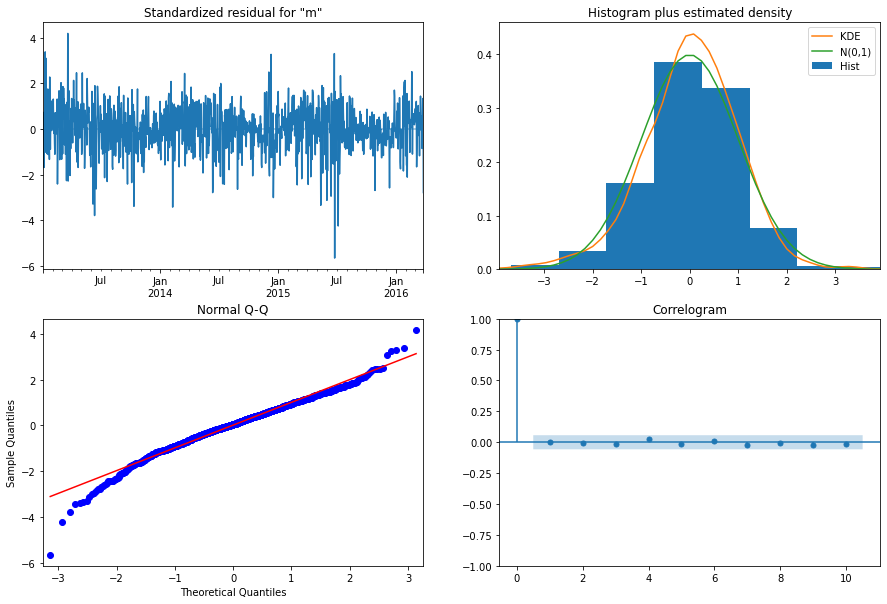

In [101]:
res_arima_1 = perform_arima(5,1,3,df_train)

A partir do diagnóstico verificamos que os resíduos aparentam ser ruído branco (como deve ser em um bom ajuste).

#### ARIMA (4,1,3)

Também decidimos testar o ARIMA (4,1,3) visto que, com um olhar mais conservador, o corte na função de autocorrelação parcial pode ser visto como no lag 4.

                               SARIMAX Results                                
Dep. Variable:               meantemp   No. Observations:                 1181
Model:                 ARIMA(4, 1, 3)   Log Likelihood               -2232.546
Date:                Wed, 13 Apr 2022   AIC                           4481.092
Time:                        20:12:43   BIC                           4521.678
Sample:                    01-01-2013   HQIC                          4496.393
                         - 03-26-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1383      0.074     -1.870      0.062      -0.283       0.007
ar.L2         -0.4631      0.072     -6.461      0.000      -0.604      -0.323
ar.L3          0.5214      0.073      7.143      0.0

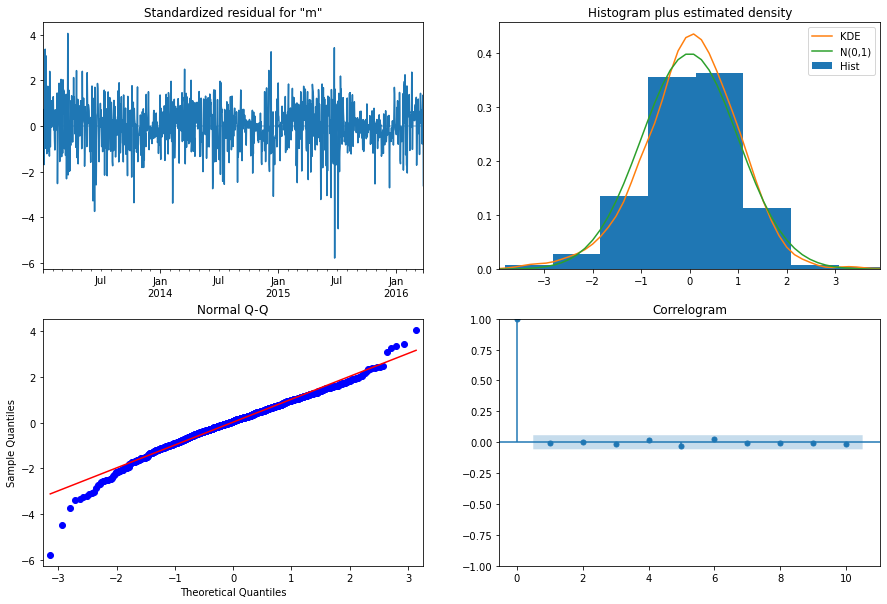

In [102]:
res_arima_2 = perform_arima(4,1,3,df_train)

A partir do diagnóstico verificamos que os resíduos aparentam ser ruído branco (como deve ser em um bom ajuste).

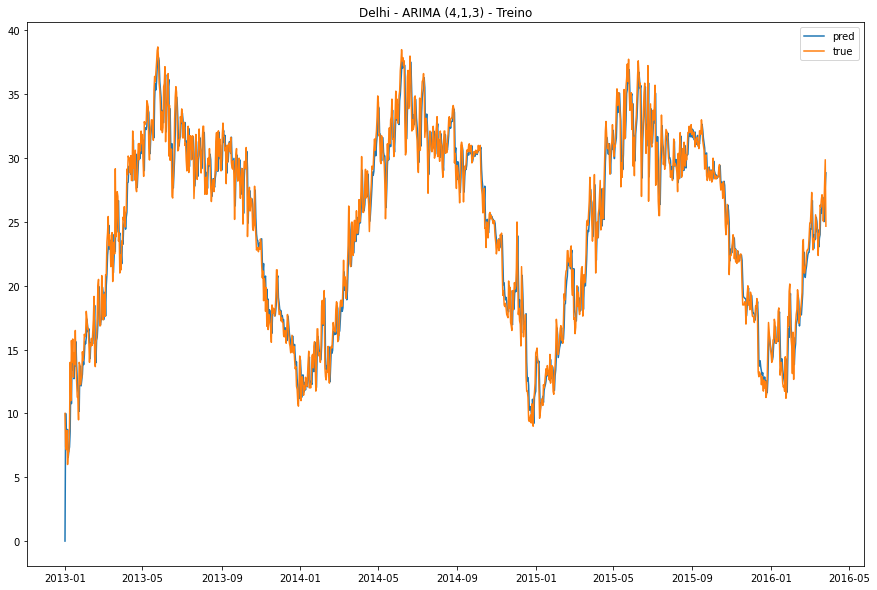

In [103]:
graf_ajuste(res_arima_2.predict(), df_train, 'Delhi - ARIMA (4,1,3) - Treino')

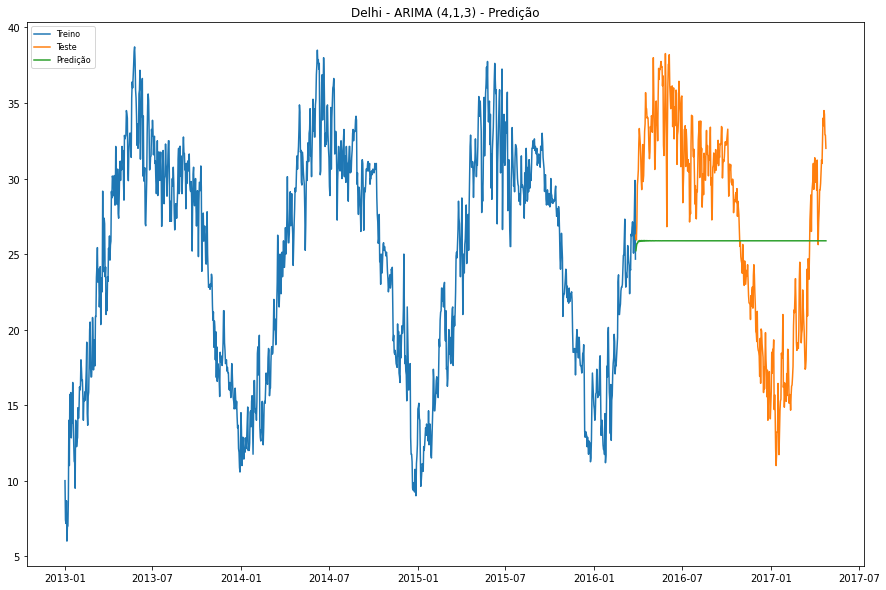

In [104]:
graf_pred(res_arima_2, df_train, df_test, 'Delhi - ARIMA (4,1,3) - Predição')

In [105]:
forecast = res_arima_2.forecast(394, alpha=0.05)
show_metrics(df_test, forecast, results, 'ARIMA(4,1,3)')

ARIMA(4,1,3) - model Results
r2 -29244.06420696393
mse 48.09442893779906
mae 6.238789808283262
mape 0.2410864250599167


#### ARIMA (0,1,3)

Como o comportamento da funções de autocorrelação e autocorrelação parcial em algumas partes não foi tão claro, sem um decaímento exponencial muito evidente, decidimos também avaliar a hipótese de que há o corte brusco na função de autocorrelação, configurando um MA(3), dessa forma avaliamos o modelo ARIMA(0,1,3).

                               SARIMAX Results                                
Dep. Variable:               meantemp   No. Observations:                 1181
Model:                 ARIMA(0, 1, 3)   Log Likelihood               -2236.505
Date:                Wed, 13 Apr 2022   AIC                           4481.009
Time:                        20:12:44   BIC                           4501.302
Sample:                    01-01-2013   HQIC                          4488.660
                         - 03-26-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2199      0.025     -8.970      0.000      -0.268      -0.172
ma.L2         -0.1197      0.025     -4.704      0.000      -0.170      -0.070
ma.L3         -0.1432      0.030     -4.837      0.0

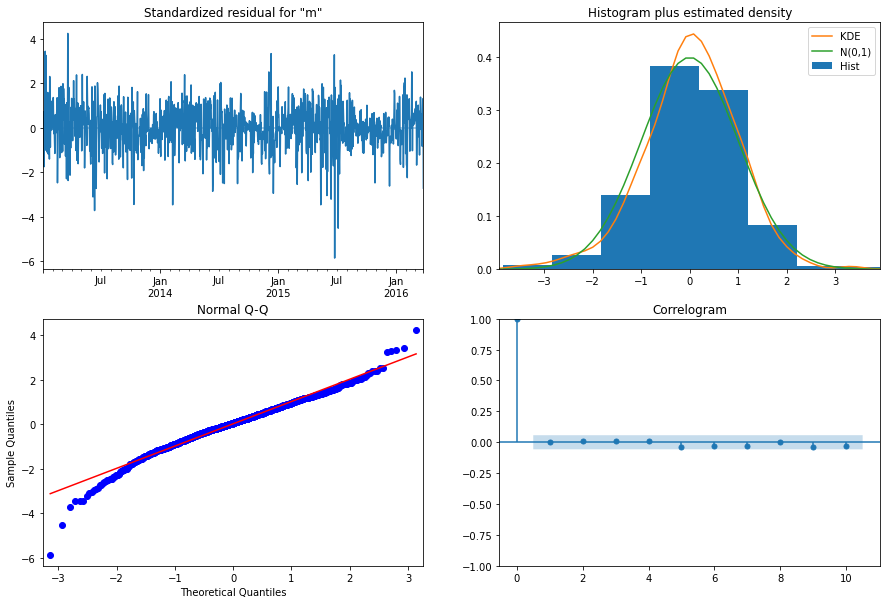

In [106]:
res_arima_3 = perform_arima(0,1,3,df_train)

A partir do diagnóstico verificamos que os resíduos aparentam ser ruído branco (como deve ser em um bom ajuste).

### Auto ARIMA

In [107]:
auto_arima = pm.auto_arima(df_train, max_ar=10, max_ma=5, max_d=2, seasonal=False, trace=True, stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=4494.045, Time=0.16 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=11018.217, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=9511.186, Time=0.06 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=4512.618, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=4492.004, Time=0.11 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=4531.154, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=4493.975, Time=0.39 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=0.93 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=4489.732, Time=0.59 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=4523.647, Time=0.24 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=4531.821, Time=0.21 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=4491.714, 

O Auto ARIMA nos informa que, dentre os modelos testados, o ARIMA (2,0,1) é o modelo com o menor AIC (Critério de Informação de Akaike)

In [108]:
auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1181
Model:               SARIMAX(2, 0, 1)   Log Likelihood               -2239.866
Date:                Wed, 13 Apr 2022   AIC                           4489.732
Time:                        20:12:51   BIC                           4515.102
Sample:                             0   HQIC                          4499.296
                               - 1181                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0506      0.030      1.672      0.094      -0.009       0.110
ar.L1          1.5616      0.055     28.192      0.000       1.453       1.670
ar.L2         -0.5638      0.055    -10.282      0.000      -0.671      -0.456
ma.L1         -0.7881      0.045    -17.488      0.000      -0.876      -0.700
sigma2         2.5920      0.086     30.135      0.000       2.423       2.761
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               227.00
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               0.98   Skew:                            -0.46
Prob(H) (two-sided):                  0.82   Kurtosis:                         4.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

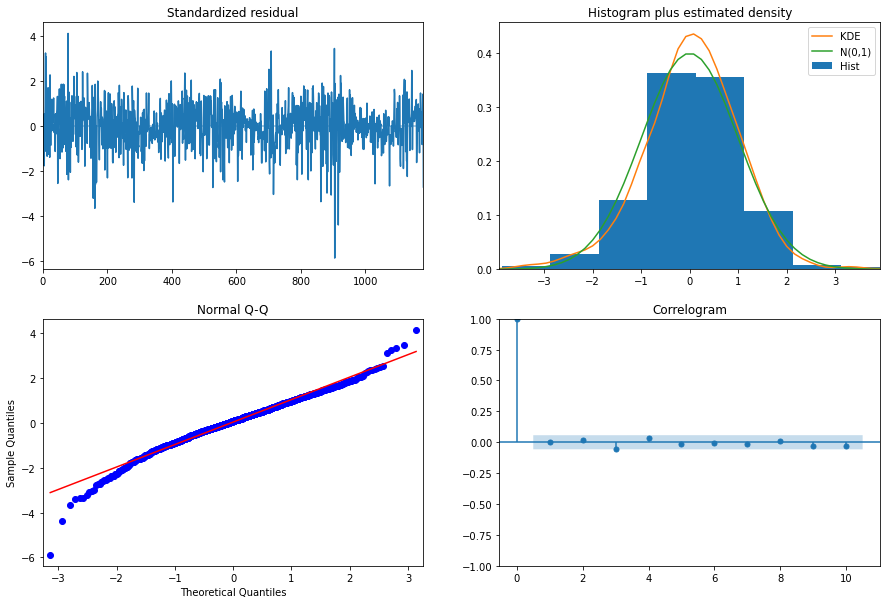

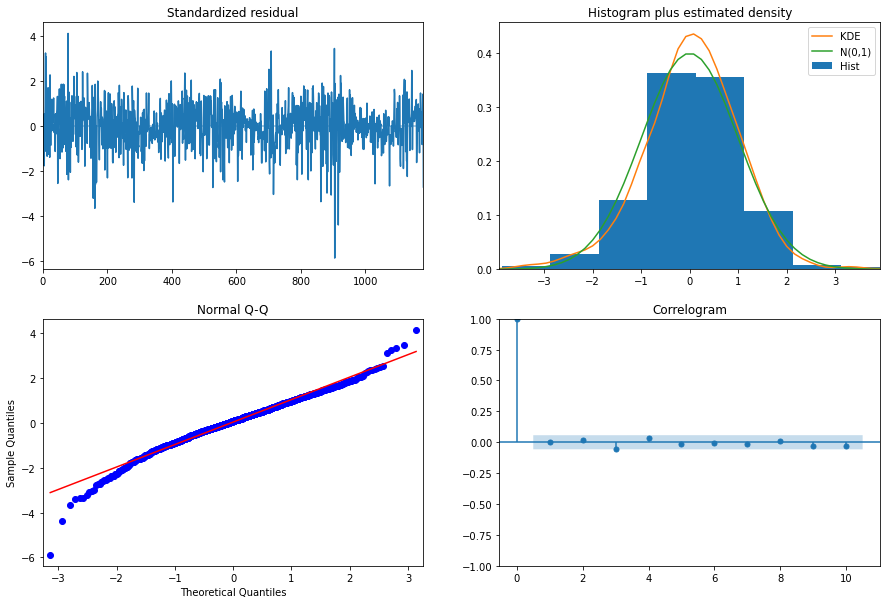

In [109]:
auto_arima.plot_diagnostics()

A partir do diagnóstico verificamos que os resíduos aparentam ser ruído branco (como deve ser em um bom ajuste).

Plotando ajuste do modelo aos dados de treino

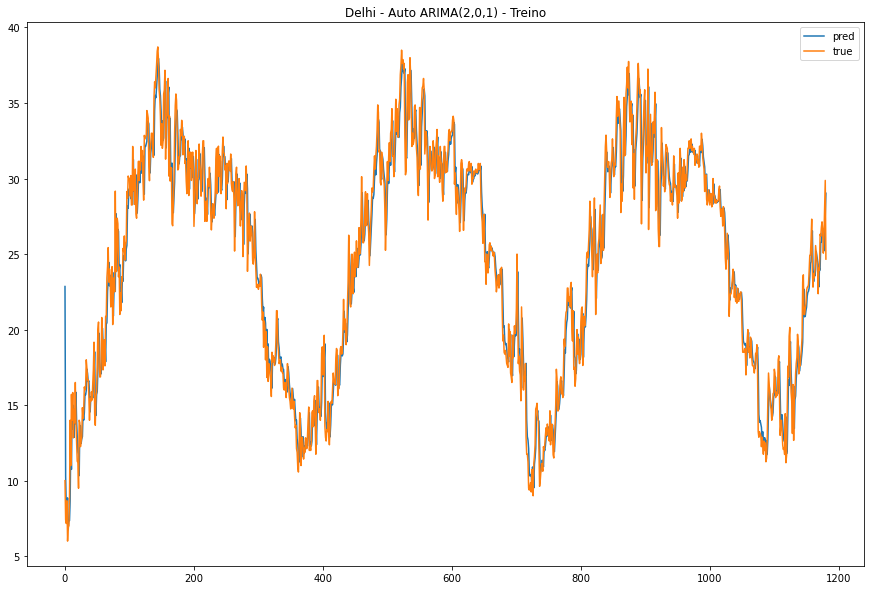

In [110]:
graf_ajuste(auto_arima.predict_in_sample(), df_train.values, 'Delhi - Auto ARIMA(2,0,1) - Treino')

Plotando Treino, teste e predição

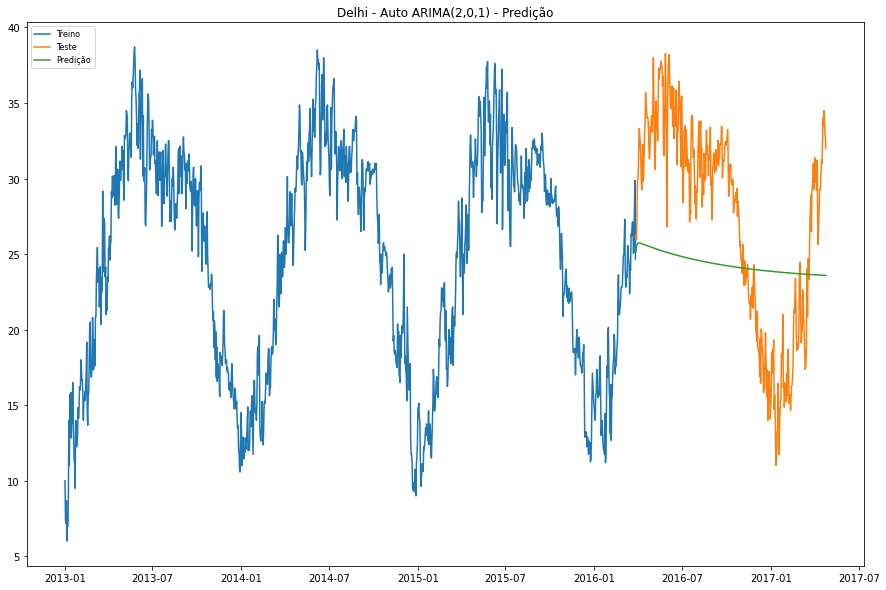

In [111]:
model = ARIMA(df_train, order=(2, 0, 1))  
fitted = model.fit()  
graf_pred(fitted, df_train, df_test, 'Delhi - Auto ARIMA(2,0,1) - Predição')

In [112]:
forecast = auto_arima.predict(n_periods=394)
show_metrics(df_test, forecast, results, 'Auto ARIMA(2,0,1)')

Auto ARIMA(2,0,1) - model Results
r2 -95.85896516856229
mse 49.68913135264666
mae 6.356182978044135
mape 0.2623335314335786


## Machine Learning

Foram gerados modelos utilizando três métodos de ML (KNN, SVR e MLP). Espera-se que com estes métodos seja possível capturar também relações não lineares existentes na série.

### Feature Engineering

Primeiramente, foi necessário realizar feature engineering no dados da série a fim de criar features relevantes para os modelos.

Foi utilizada a função **get_lags**, a qual criava features que correspodem a atrasos da série temporal. O número de atrasos pode ser determinado como parâmetro da função.

In [113]:
#time travel
def get_lags(series, lags):
  result = []
  if lags > 0:
    for lag in range(1, lags+1):
    #  print(lag)
    #  print(series.shift(lag))
      result.append(series.shift(lag).rename({series.columns[0]: series.columns[0]+'-'+str(lag)}, axis=1))
    #return result
    return pd.concat(result, axis=1, names=list(range(-1,-lags))).dropna()
  else:
    for lag in range(-1, lags-1,-1):
      #print(lag)
      #print(series.shift(lag))
      result.append(series.shift(lag).rename({series.columns[0]: series.columns[0]+'+'+str(abs(lag))}, axis=1))
    #return result
    return pd.concat(result, axis=1, names=list(range(+1,-lags))).dropna()

Decidimos utilizar o número de lags 5, assim foram criadas 5 novas features com os atrasos para a série.

In [114]:
X = get_lags(df, 5)
X.head()

,meantemp-1,meantemp-2,meantemp-3,meantemp-4,meantemp-5
date,,,,,
2013-01-06,6.000000,8.666667,7.166667,7.400000,10.000000
2013-01-07,7.000000,6.000000,8.666667,7.166667,7.400000
2013-01-08,7.000000,7.000000,6.000000,8.666667,7.166667
2013-01-09,8.857143,7.000000,7.000000,6.000000,8.666667
2013-01-10,14.000000,8.857143,7.000000,7.000000,6.000000


In [115]:
y = df.reindex(X.index)
y.head()

,meantemp
date,
2013-01-06,7.000000
2013-01-07,7.000000
2013-01-08,8.857143
2013-01-09,14.000000
2013-01-10,11.000000


### Separando os dados

Os dados foram separados em treino e teste, para serem utilizado no GridSearch. Como o ScikitLearn separa os dados de validação, o conjunto de teste abaixo já contém o conjunto de validação.

In [116]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=.25)

### KNN

Utilizamos o GridSearch para encontrar os melhores parâmetros para o KNN. Foram utilizados dois hiperâmetros: o número de vizinhos(n_neighbors) e o peso (weights). 

In [117]:
#Definindo hiperpâmetros de busca do GridSearch
parameters = {'n_neighbors':range(1,20), 'weights':["uniform", "distance"]}
for p in parameters.items():
  print(p)

('n_neighbors', range(1, 20))
('weights', ['uniform', 'distance'])


In [118]:
knn = KNeighborsRegressor()
knnGS = GridSearchCV(knn, parameters, cv=TimeSeriesSplit(n_splits=10))
res = knnGS.fit(X_train, y_train)
print(res.best_score_)
print(res.best_params_)

0.5552656984094178
{'n_neighbors': 13, 'weights': 'uniform'}


Métricas

In [119]:
prediction = res.predict(X_test)
show_metrics(y_test, prediction, results, 'KNN GS')

KNN GS - model Results
r2 0.925177948391813
mse 3.0851600300035686
mae 1.388425236069681
mape 0.054733868043331656


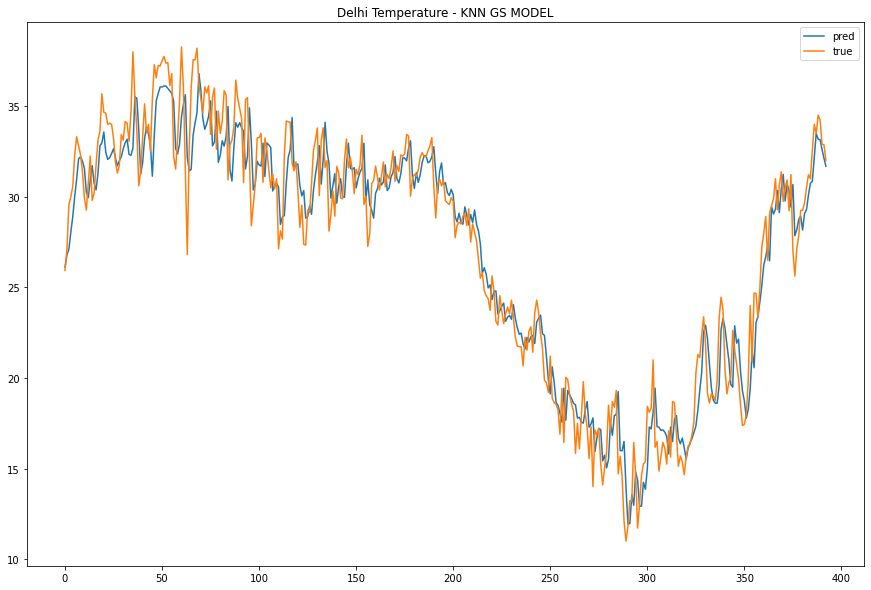

In [120]:
graf_ajuste(prediction, y_test.reset_index(drop=True), 'Delhi Temperature - KNN GS MODEL')


<AxesSubplot:>

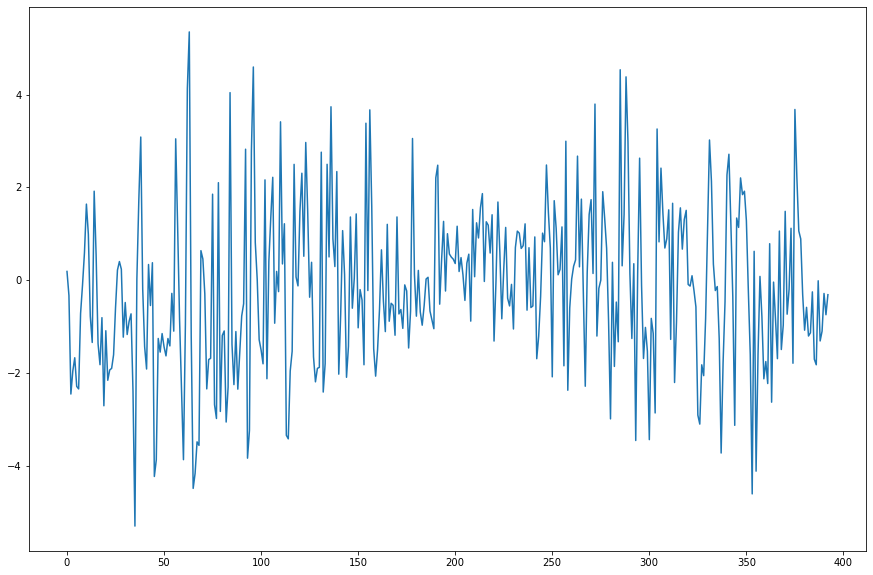

In [121]:
residuos = prediction.flatten() - y_test.reset_index(drop=True).values.flatten()
pd.Series(residuos).plot()

<AxesSubplot:ylabel='Density'>

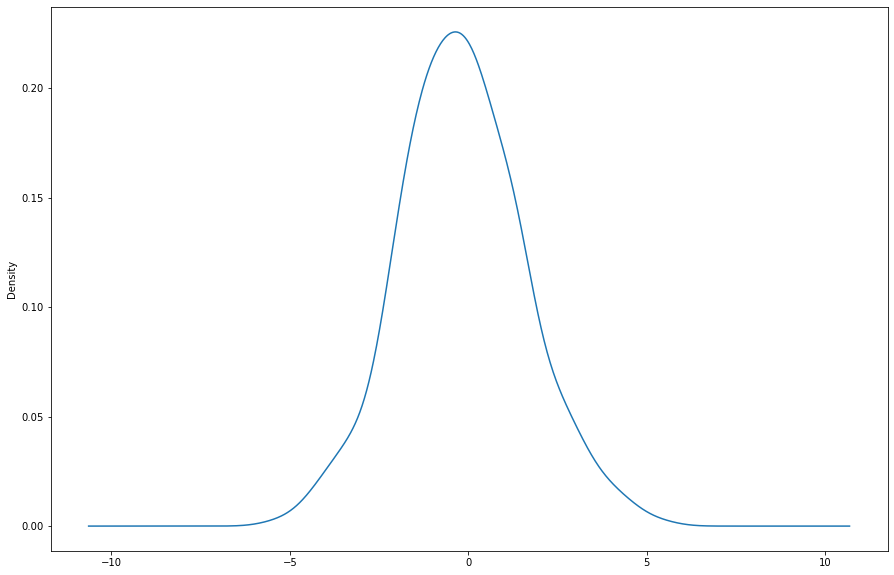

In [122]:
pd.Series(residuos).plot.kde()

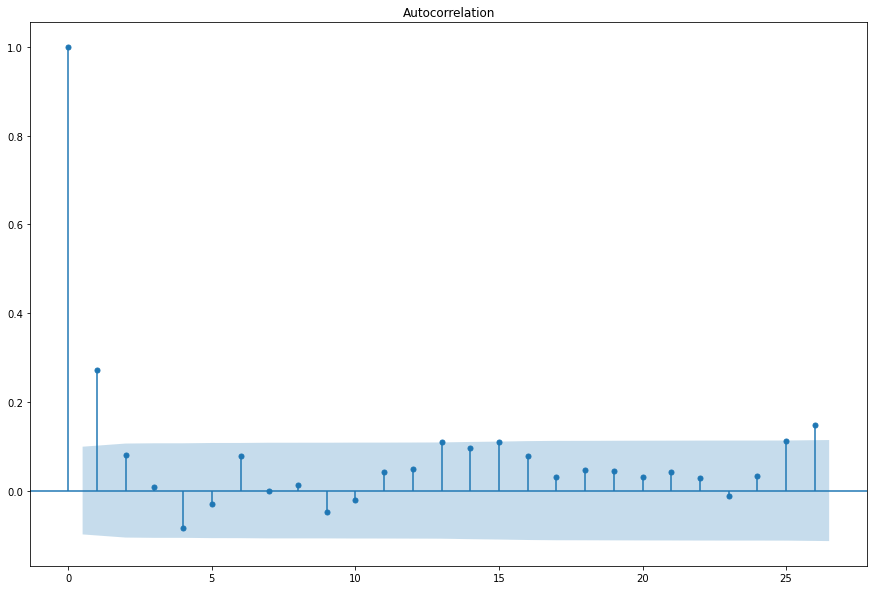

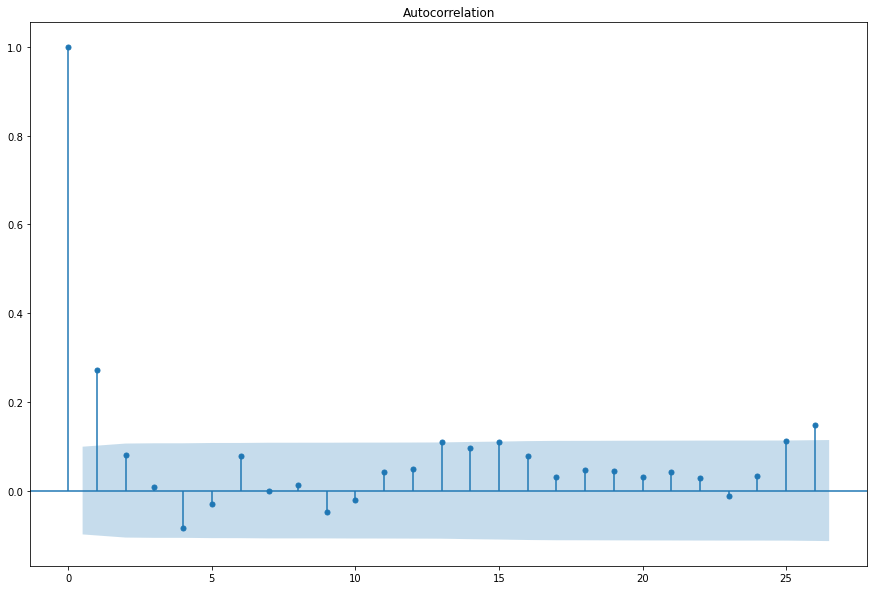

In [123]:
plot_acf(residuos)

Abaixo verificamos que o modelo se ajustou de acordo com as métricas. No entanto, abaixo foi feito o KNN com a série diferenciada. 

#### KNN com série difenciada

In [124]:
#Diferenciando
X_train_d1 = X_train.diff().dropna()
X_test_d1 = X_test.diff().dropna()
y_train_d1 = y_train.diff().dropna()
y_test_d1 = y_test.diff().dropna()

In [125]:
res_diff = knnGS.fit(X_train_d1, y_train_d1)
print(res_diff.best_score_)
print(res_diff.best_params_)

0.0005051500227615136
{'n_neighbors': 18, 'weights': 'uniform'}


In [126]:
prediction_diff = res_diff.predict(X_test_d1)
show_metrics(y_test_d1, prediction_diff, results, 'd1 KNN GS')

d1 KNN GS - model Results
r2 -14.670800250744529
mse 2.7334225378254953
mae 1.2659808328561508
mape 45.83371059241627


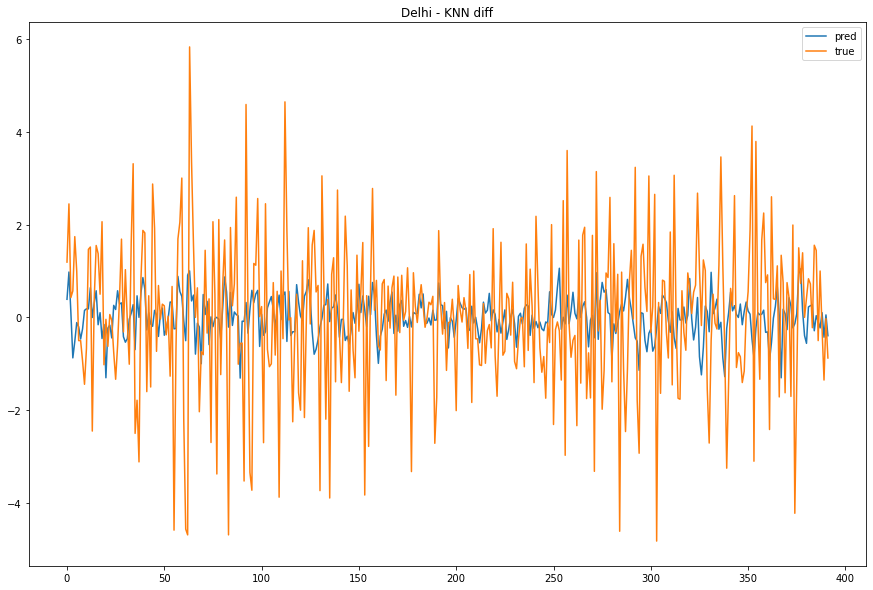

In [127]:
graf_ajuste(pd.Series(prediction_diff.flatten()), y_test_d1.reset_index(drop=True), 'Delhi - KNN diff')

One step 


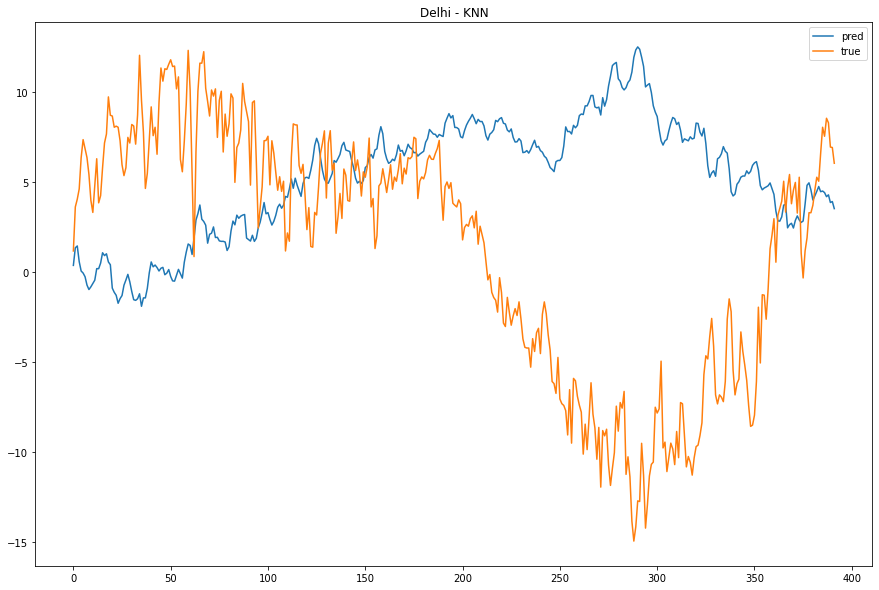

In [128]:
graf_ajuste(pd.Series(prediction_diff.flatten()).cumsum(), y_test_d1.reset_index(drop=True).cumsum(), 'Delhi - KNN')

Como o gráfico apresentou bastante variação do valor real, decidimos utilizar o valor real para ajustar a predição. 

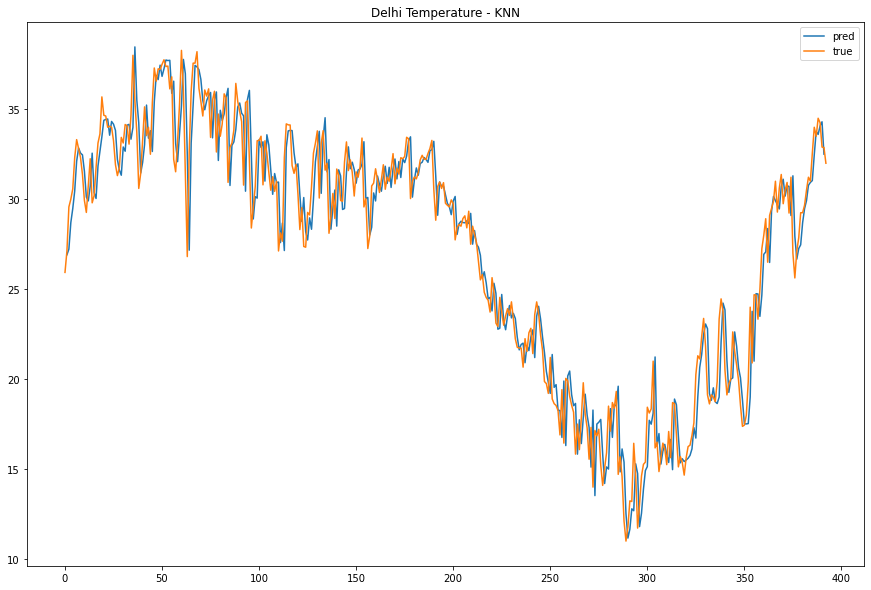

In [129]:
pred_one = y_test.shift(1).reset_index(drop=True).add(pd.Series(prediction_diff.flatten(), name='temperature'),axis=0)
graf_ajuste(pred_one, y_test.reset_index(drop=True), 'Delhi Temperature - KNN')

In [130]:
show_metrics(y_test.iloc[1:-1], pred_one.iloc[1:-1], results, 'pred one KNN GS')

pred one KNN GS - model Results
r2 0.9325385055689803
mse 3.1470734417768313
mae 1.3138804267176756
mape 0.05348903321925905


In [131]:
residuos = prediction_diff.flatten() - y_test_d1.reset_index(drop=True).values.flatten()

<AxesSubplot:>

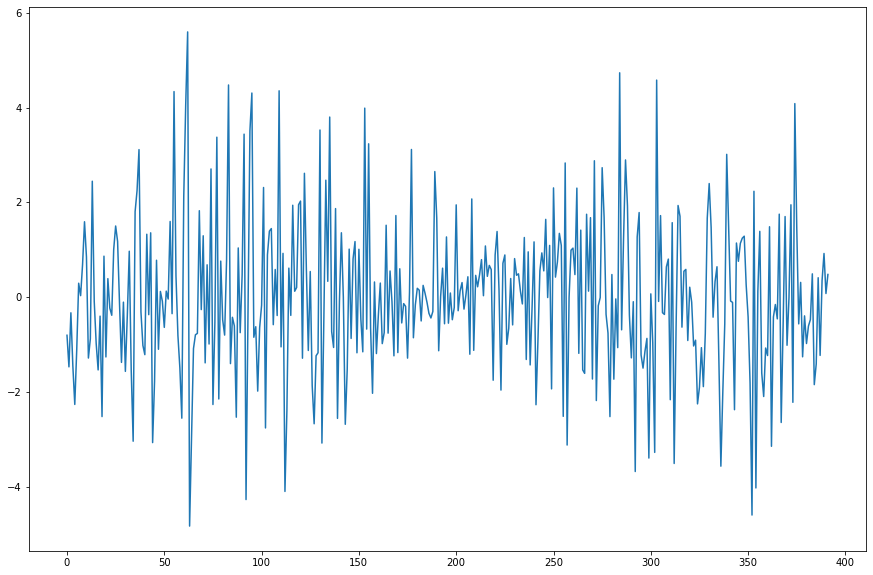

In [132]:
pd.Series(residuos).plot()

<AxesSubplot:ylabel='Density'>

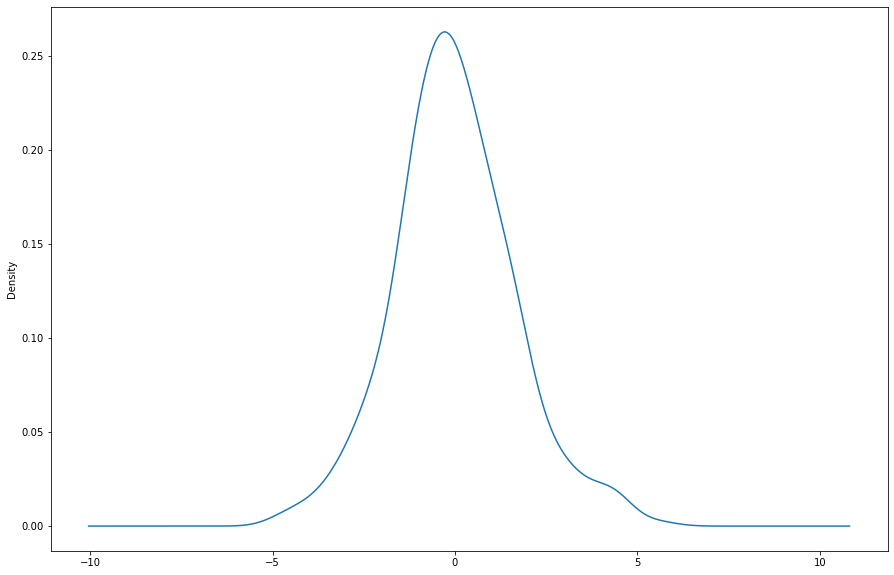

In [133]:
pd.Series(residuos).plot.kde()

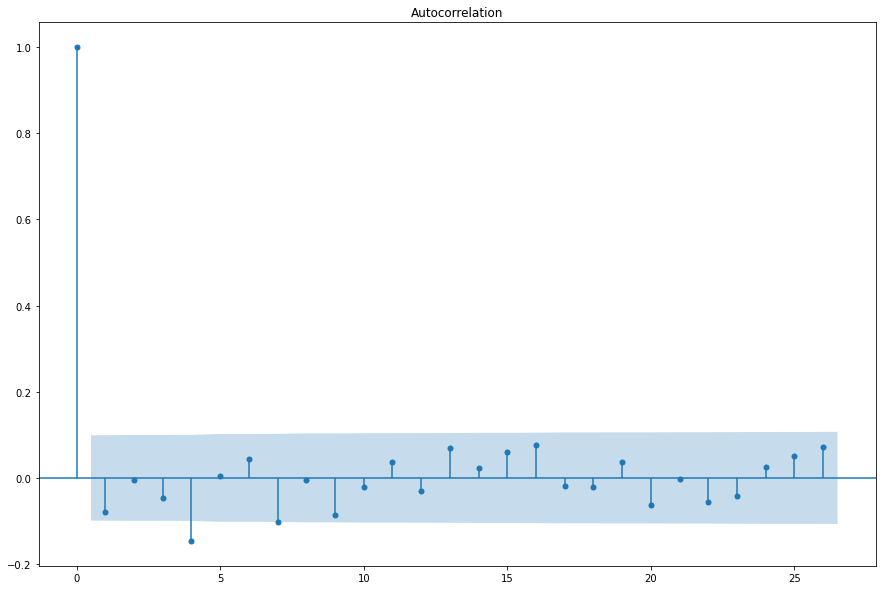

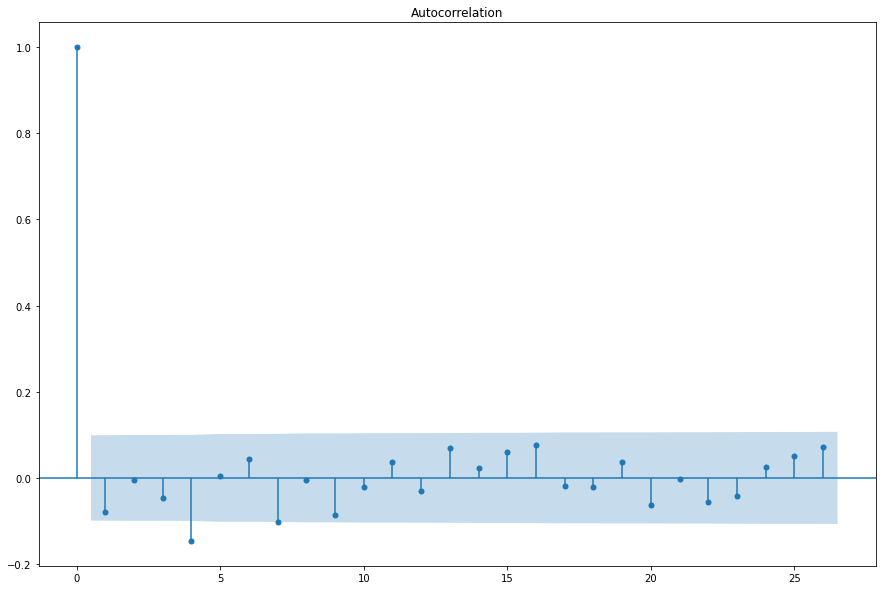

In [134]:
plot_acf(residuos)

As métricas mostraram valores promissores para o modelo KNN diferenciado.

### Support Vector Regression

Aqui utilizaremos o Support Vector Regression, primeiro vamos ajustar um modelo simples e depois tentar melhorar os parâmetros.

In [135]:
from sklearn.svm import SVR

regr = SVR(C=1.0, epsilon=0.2, kernel='linear')

regr.fit(X_train, y_train)

SVR(epsilon=0.2, kernel='linear')

In [136]:
forecast = regr.predict(X_test)
show_metrics(y_test, forecast, results, 'SVR')

SVR - model Results
r2 0.9420851523958013
mse 2.6335673568344924
mae 1.238467119881532
mape 0.049395729366067884


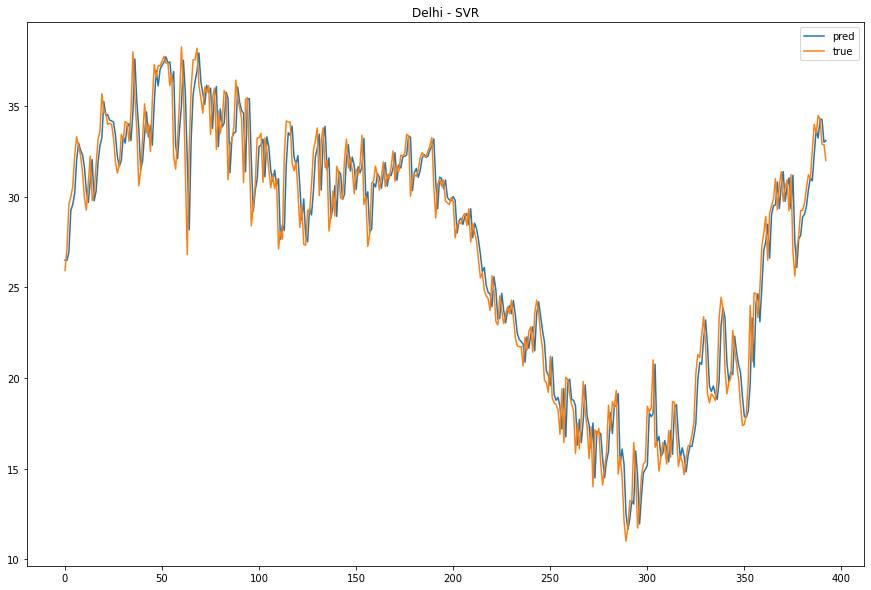

In [137]:
graf_ajuste(regr.predict(X_test), y_test.reset_index(drop=True), 'Delhi - SVR')

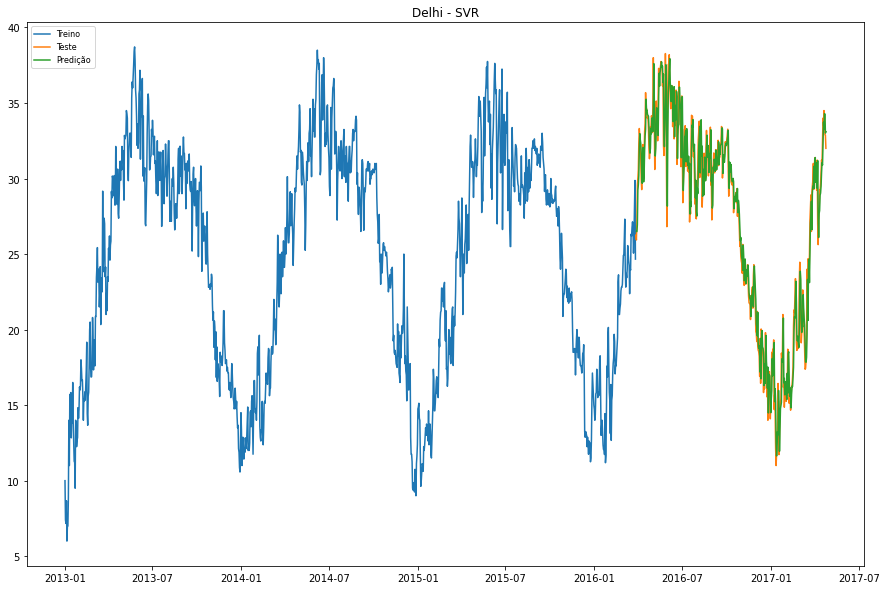

In [138]:
graf_pred(regr.predict(X_test), df_train, df_test, 'Delhi - SVR', SVR=True)

Verificamos que o modelo ajustou muito bem aos dados e fez predições do conjunto de teste muito próximas dos valores reais, como podemos verificar nos gráficos acima e nas métricas de avaliação.

#### Grid Search

Agora vamos utilizar o GridSearch para explorar diferentes parâmetros e do SVR e encontrar os melhores.

In [139]:
#parameters = {'kernel':['linear','rbf', 'sigmoid', 'polynomial'], 
#              'C':np.linspace(0.05, 10, 20),
#              'gamma':np.linspace(.1, 10, 3),
#              'coef0':np.linspace(.01, 10, 3),
#              'degree':np.arange(2, 3)
#              }

#for p in parameters.items():
#  print(p)

In [140]:
#regr2 = SVR()
#regrGS = GridSearchCV(regr2, parameters, cv=TimeSeriesSplit(n_splits=10))

In [141]:
#res = regrGS.fit(X_train, y_train)

Após executar o GridSearch obtivemos como melhor score e parâmetros:

In [142]:
print(res.best_score_)
print(res.best_params_)
#'C': 0.1, 'coef0': 0.01, 'degree': 2, 'gamma': 0.1, 'kernel': 'linear'
#12 minutos


#'C': 7.788888888888888, 'coef0': 0.01, 'degree': 2, 'gamma': 0.1, 'kernel': 'linear'}
#5 minutos

#{'C': 7.38157894736842, 'coef0': 0.01, 'degree': 2, 'gamma': 0.1, 'kernel': 'linear'}
#18 min

0.0005051500227615136
{'n_neighbors': 18, 'weights': 'uniform'}


In [143]:
regr2 = SVR(C=7.38, kernel='linear')
res = regr2.fit(X_train, y_train)

In [144]:
forecast = regr2.predict(X_test)
show_metrics(y_test, forecast, results, 'SVR GS')

SVR GS - model Results
r2 0.9419375822145339
mse 2.646133637607021
mae 1.2406032840965684
mape 0.049477138680166184


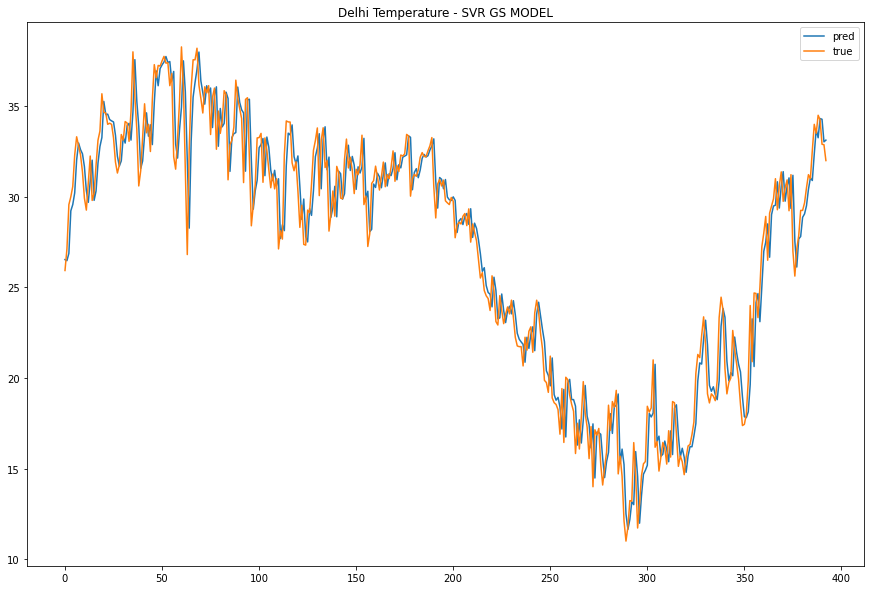

In [145]:
graf_ajuste(res.predict(X_test), y_test.reset_index(drop=True), 'Delhi Temperature - SVR GS MODEL')

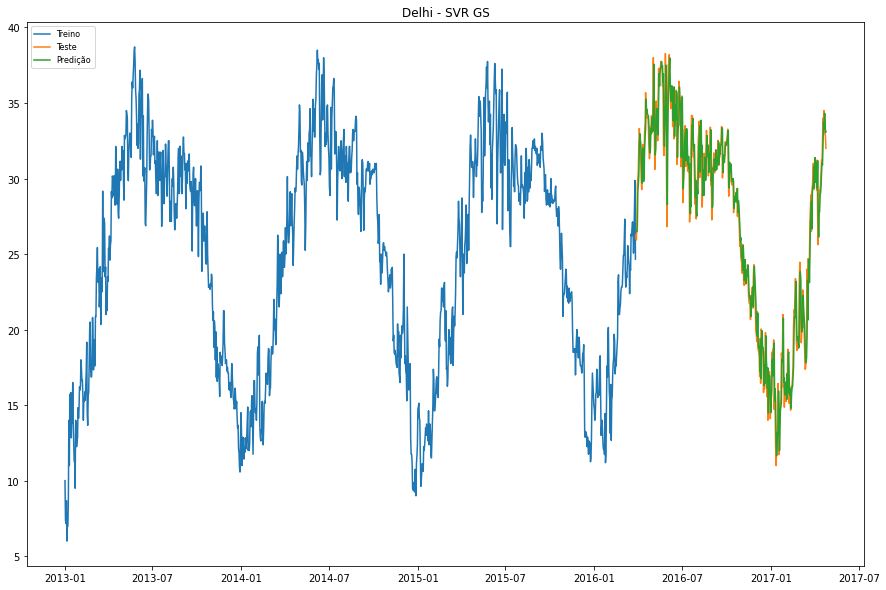

In [146]:
graf_pred(res.predict(X_test), df_train, df_test, 'Delhi - SVR GS', SVR=True)

Verificando Overfitting

In [147]:
train_sizes, train_scores, valid_scores = learning_curve(
    SVR(kernel='linear'), X, y, train_sizes=[50,100,150,200,250], cv=TimeSeriesSplit())
    #SVR(kernel='linear'), X, y, train_sizes=[np.round(np.array(list(range(0.1,1,0.1))) * len(y))], cv=TimeSeriesSplit())

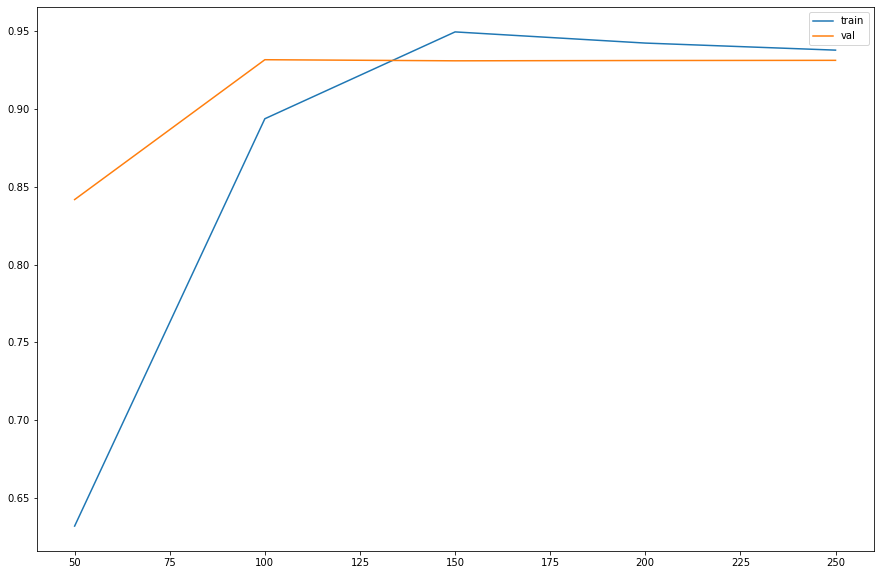

In [148]:
pd.Series(train_scores.mean(axis=1), index=train_sizes).plot(label='train')
pd.Series(valid_scores.mean(axis=1), index=train_sizes).plot(label='val')
plt.legend()

A partir do gráfico acima não aparenta haver Overfit.

### MLP

In [149]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.optim as optim

#### Divisão de Dados MLP 

In [150]:
#Separando os dados
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=.25)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, shuffle=False, test_size=.25)

#### Diferenciação

In [151]:
#Diferenciando
X_train_d1 = X_train.diff().dropna()
X_valid_d1 = X_valid.diff().dropna()
X_test_d1 = X_test.diff().dropna()
y_train_d1 = y_train.diff().dropna()
y_valid_d1 = y_valid.diff().dropna()
y_test_d1 = y_test.diff().dropna()

#### Normalização

In [152]:
X_train_d1_norm = X_train_d1.sub(X_train_d1.mean()).div(X_train_d1.std())
X_valid_d1_norm = X_valid_d1.sub(X_valid_d1.mean()).div(X_valid_d1.std())
X_test_d1_norm = X_test_d1.sub(X_train_d1.mean()).div(X_train_d1.std())

<AxesSubplot:xlabel='date'>

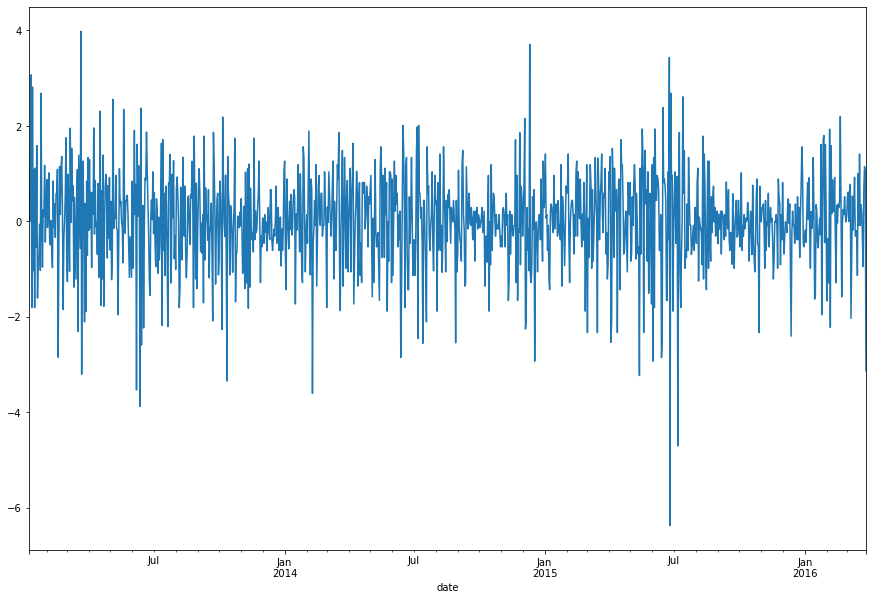

In [153]:
X_train_d1_norm['meantemp-1'].plot()

<AxesSubplot:title={'center':'train'}, ylabel='Frequency'>

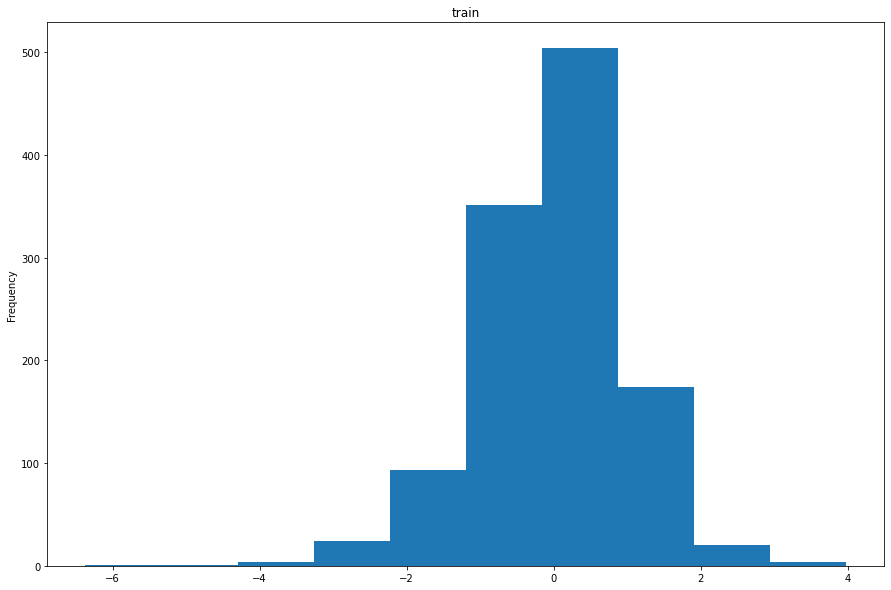

In [154]:
X_train_d1_norm['meantemp-1'].plot.hist(title='train')

<AxesSubplot:title={'center':'validation'}, ylabel='Frequency'>

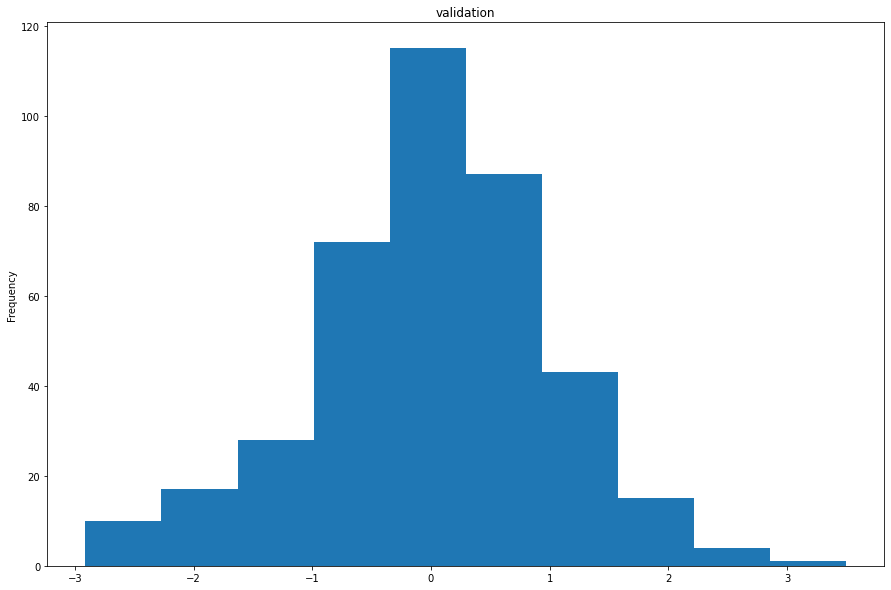

In [155]:
X_valid_d1_norm['meantemp-1'].plot.hist(title='validation')

<AxesSubplot:title={'center':'test'}, ylabel='Frequency'>

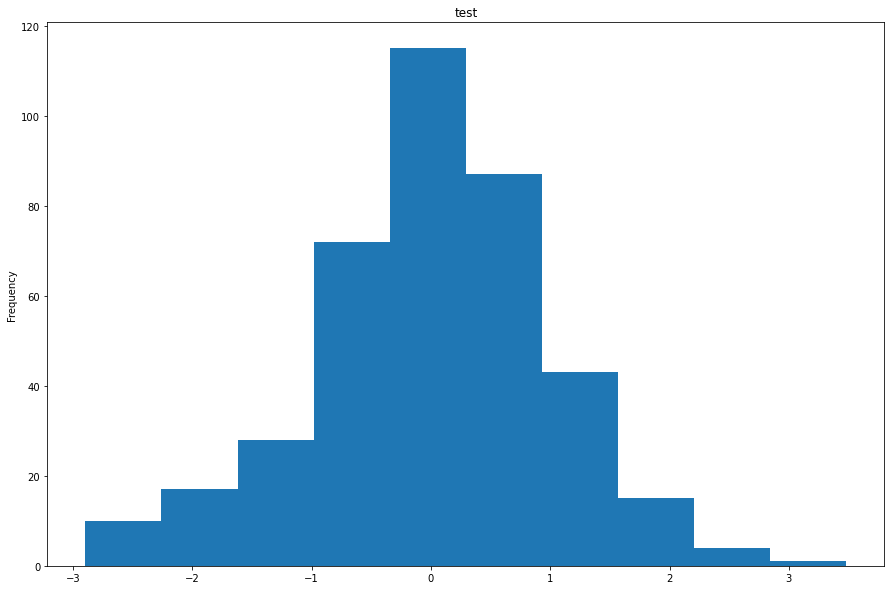

In [156]:
X_test_d1_norm['meantemp-1'].plot.hist(title='test')


#### Batches

In [157]:
training_data = torch.tensor(pd.concat([X_train_d1_norm, y_train_d1], axis=1).values)
validating_data = torch.tensor(pd.concat([X_valid_d1_norm, y_valid_d1], axis=1).values)
testing_data = torch.tensor(pd.concat([X_test_d1_norm, y_test_d1], axis=1).values)


In [158]:
train_dataloader = DataLoader(training_data, batch_size=16, shuffle=False)
valid_dataloader = DataLoader(validating_data, batch_size=16, shuffle=False)
test_dataloader = DataLoader(testing_data, batch_size=16, shuffle=False)

#### Modelo MLP

In [159]:
class MLP(nn.Module):
  def __init__(self):
    super().__init__()
    
    #Config 1
    # self.fc1 = nn.Linear(5,100)
    # self.fc3 = nn.Linear(100,1)
    
    #Config 2
    # self.fc1 = nn.Linear(5,32)
    # self.fc2 = nn.Linear(32,64)
    # self.fc3 = nn.Linear(64,1)
     
    # #Config 3
    self.fc1 = nn.Linear(5,32)
    self.drop1 = nn.Dropout(p=0.5)
    self.fc2 = nn.Linear(32,64)
    self.drop2 = nn.Dropout(p=0.5)
    self.fc3 = nn.Linear(64,1)
  
  def forward(self, X):
    out = torch.tanh(self.fc1(X))
    out = self.drop1(out)
    out = torch.relu(self.fc2(out))
    out = self.drop2(out)
    out = self.fc3(out)
    return out

In [160]:
multi_neuron = MLP()
print(multi_neuron(torch.tensor(X_train_d1.iloc[0]).float()))
print(y_train_d1.iloc[0])

tensor([-0.1602], grad_fn=<AddBackward0>)
meantemp    0.0
Name: 2013-01-07 00:00:00, dtype: float64


In [161]:
multi_neuron = MLP()
epochs = 300
loss_fn = nn.MSELoss()
#optimizer = optim.RMSprop(multi_neuron.parameters(), lr=0.001)
optimizer = optim.SGD(multi_neuron.parameters(), lr=0.01, weight_decay= 0.005)

Epoch10, train loss 2.8064381041236826
Epoch10, valid loss 2.7220851230621337
Epoch20, train loss 2.8044703796103194
Epoch20, valid loss 2.7232503390312193
Epoch30, train loss 2.8034602351285316
Epoch30, valid loss 2.721805944442749
Epoch40, train loss 2.802803294078724
Epoch40, valid loss 2.7218997538089753
Epoch50, train loss 2.8036792987101786
Epoch50, valid loss 2.721590106487274
Epoch60, train loss 2.803029347915907
Epoch60, valid loss 2.721636226177216
Epoch70, train loss 2.8032972293125615
Epoch70, valid loss 2.72186061501503
Epoch80, train loss 2.802845981072735
Epoch80, valid loss 2.7242718315124512
Epoch90, train loss 2.80256968978289
Epoch90, valid loss 2.723515090942383
Epoch100, train loss 2.8026039419141977
Epoch100, valid loss 2.7213316059112547
Epoch110, train loss 2.8030503303618044
Epoch110, valid loss 2.7214038980007174
Epoch120, train loss 2.8021267322269647
Epoch120, valid loss 2.7214838886260986
Epoch130, train loss 2.8032170848266498
Epoch130, valid loss 2.721946

<AxesSubplot:>

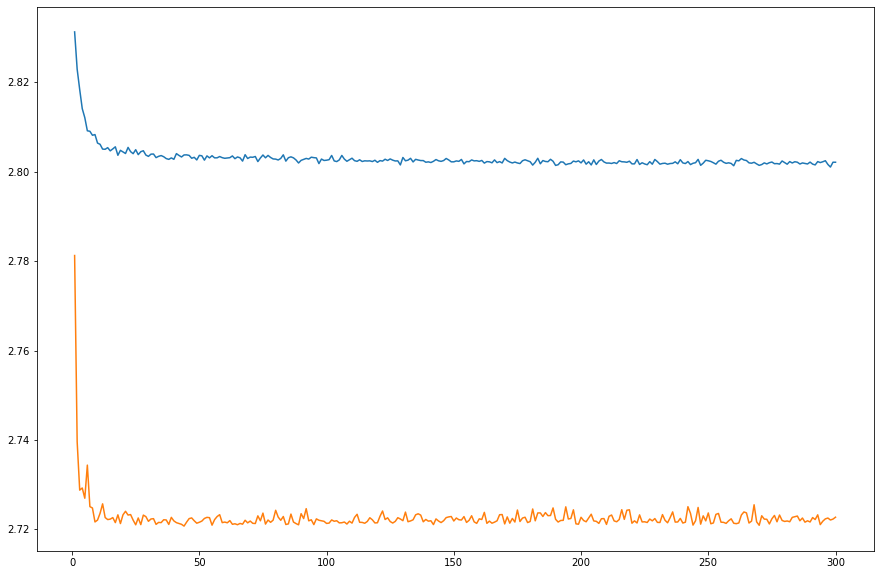

In [162]:
history_train = {}
history_valid = {}
for epoch in range(1, epochs+1):
  loss_train = 0.0
  for train_data in train_dataloader:
    x = train_data[:,:5].float()
    y = train_data[:,5].float()
  
    #forward pass
    outputs = multi_neuron(x)

    #loss measure
    loss = loss_fn(outputs,y)

    #backward pass
    optimizer.zero_grad() # pára o autograd
    loss.backward() # executa o backpropagation
    optimizer.step() # atualiza os pesos

    loss_train += loss.item() # soma os erros para obter o erro total

  loss_valid = 0.0
  for valid_data in valid_dataloader:    
    x = valid_data[:,:5].float()
    y = valid_data[:,5].float()   
    #forward pass
    target = multi_neuron(x)
    #loss measure
    loss = loss_fn(outputs,y)
    # Calculate Loss
    loss_valid += loss.item()


  if (epoch % 10 == 0):
    print('Epoch{}, train loss {}'.format(epoch, loss_train / len(train_dataloader)))
    print('Epoch{}, valid loss {}'.format(epoch, loss_valid / len(valid_dataloader))) # apresenta o erro médio da época
  history_train[epoch] = loss_train / len(train_dataloader)
  history_valid[epoch] = loss_valid / len(valid_dataloader)

pd.Series(history_train).plot()
pd.Series(history_valid).plot()

#pd.Series(train_scores.mean(axis=1), index=train_sizes).plot(label='train')
#pd.Series(valid_scores.mean(axis=1), index=train_sizes).plot(label='val')
#plt.legend()

<AxesSubplot:>

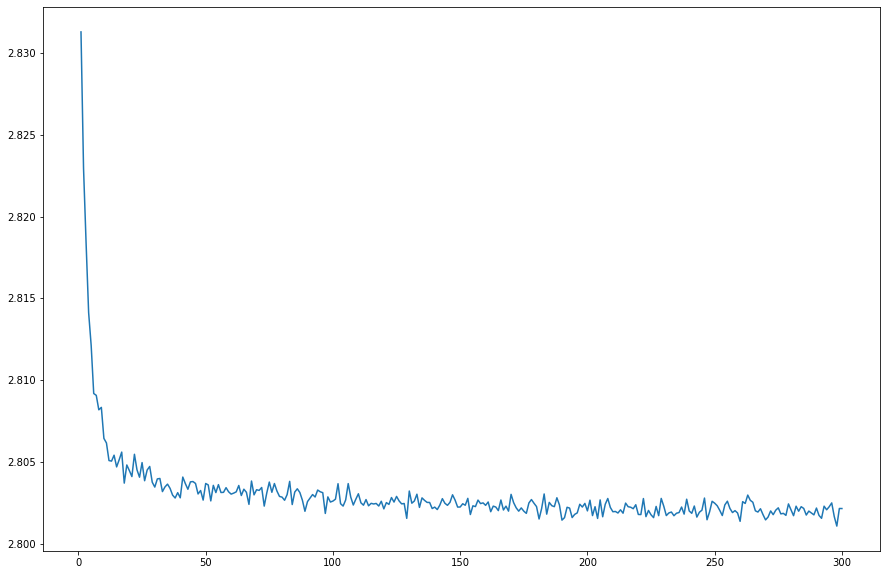

In [163]:
pd.Series(history_train).plot()

In [164]:
multi_neuron.eval()
results_MLP = []
for test_data in test_dataloader:
    x = test_data[:,:5].float()
    y = test_data[:,5].float()
    
    y_pred = multi_neuron(x)
    results_MLP.extend(y_pred.flatten().detach().numpy())
#pd.DataFrame(results).plot()
results_MLP[:10]

[-0.009813789,
 -0.0155414995,
 0.028540865,
 0.09104392,
 0.07616154,
 0.10979746,
 0.10137048,
 0.050025642,
 0.028335527,
 -0.0066447333]

<AxesSubplot:>

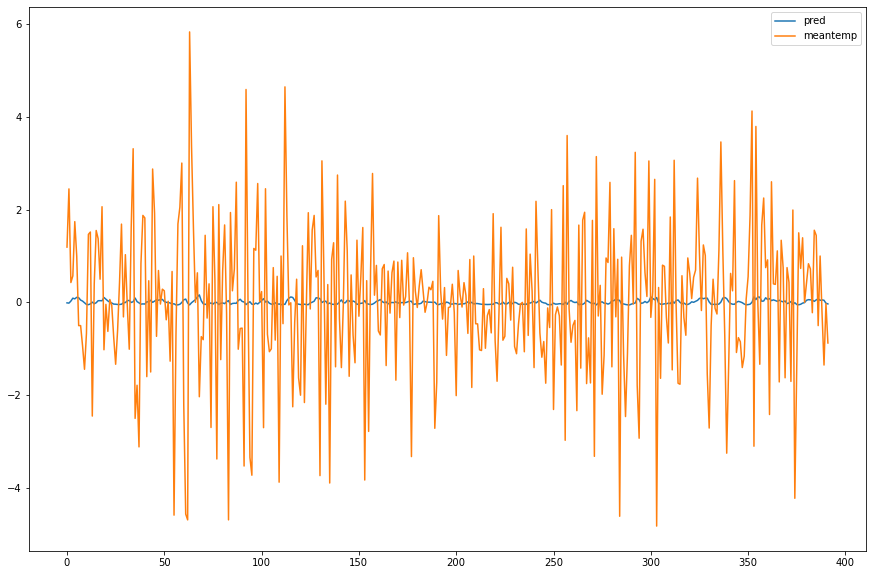

In [165]:
pd.concat([pd.Series(results_MLP, name='pred'), y_test_d1.reset_index(drop=True)],axis=1).plot()

In [166]:
show_metrics(y_test_d1,results_MLP, results, 'MLP')

MLP - model Results
r2 -1516.8321650882374
mse 2.786895383367052
mae 1.2686764679705531
mape 106.20372340358911


In [167]:
pd.DataFrame(results)

,"ARIMA(4,1,3)","Auto ARIMA(2,0,1)",KNN GS,d1 KNN GS,pred one KNN GS,SVR,SVR GS,MLP
r2,-29244.064207,-95.858965,0.925178,-14.670800,0.932539,0.942085,0.941938,-1516.832165
mse,48.094429,49.689131,3.085160,2.733423,3.147073,2.633567,2.646134,2.786895
mae,6.238790,6.356183,1.388425,1.265981,1.313880,1.238467,1.240603,1.268676
mape,0.241086,0.262334,0.054734,45.833711,0.053489,0.049396,0.049477,106.203723


# Dúvidas

- Pela metodologia Box and Jenkins podemos usar o AUTO ARIMA ou devemos testar na mão diferentes ARIMAS?

- Como devemos fazer a previsao do ARIMA? Atualmente, estamos utilizando forecast e colocando o tamanho do conjunto de observações do teste, é isso mesmo?

- O modelo que acreditamos que era melhor não bateu com o do auto-arima e agora?

- Nossa predição do ARIMA tá bem estranha, ficou uma linha. Achamos estranho, pois nossa série parece bem comportada.

- Para fazer a validação com 10 repetições no GridSearch, fizemos uso de n_splits = 10 dentro de TimeSeriesSplit, é isso mesmo? -> Se for isso, como vamos dividir em 25% de validação? 

- Devemos fazer essa mesma metodologia de n_splits = 10 na MLP? Porque parece bem trabalhoso, pois não sabemos como o pytorch faria isso, devemos escrever o código? 